# Land use

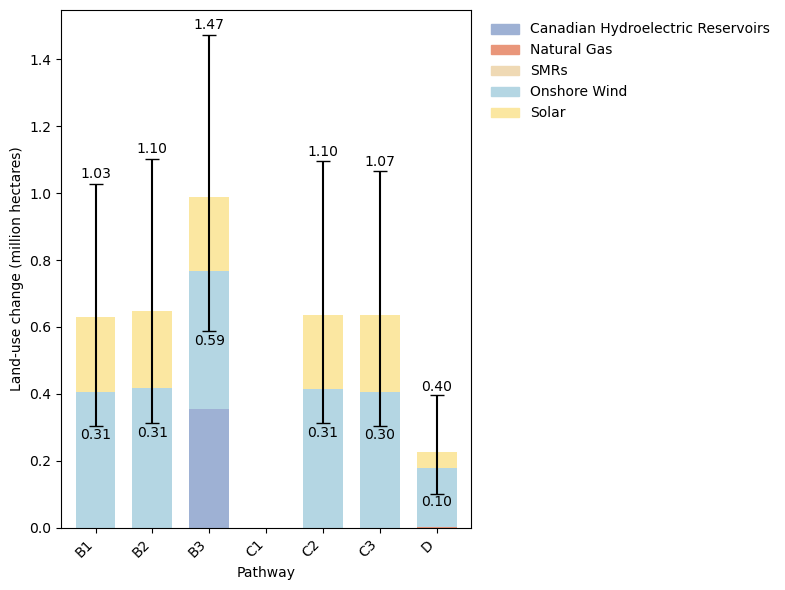

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/1 Decarbonization Pathways/Decarbonization_Pathways.xlsx"

# Read all sheets into a dictionary
all_sheets = pd.read_excel(file_path, sheet_name=None)

# List to hold DataFrames
df_list = []

# Iterate over each sheet
for sheet_name, df in all_sheets.items():
    df['Pathway'] = sheet_name  # Add the 'Pathway' column
    df_list.append(df)

# Concatenate all DataFrames into one
decarb_pathways = pd.concat(df_list, ignore_index=True)

# 0) reproducibility and Monte Carlo settings
np.random.seed(42)
n_sims = 1000

# 1) manual Canadian hydro injection for B3
b3_hydro_map = {2025: 0, 2050: 3692.308}
decarb_pathways['Canadian Hydro'] = 0.0
mask_b3 = decarb_pathways['Pathway'] == 'B3'
decarb_pathways.loc[mask_b3, 'Canadian Hydro'] = (
    decarb_pathways.loc[mask_b3, 'Year']
                  .map(b3_hydro_map)
                  .fillna(0)
)

# 2) distribution parameters (ha per MW)
dist_params = {
    'Canadian Hydro': ('uniform', (43.1, 146.7)),
    'New NG':         ('fixed',   0.032),
    'SMR':            ('fixed',   0.017),
    'Onshore Wind':   ('gamma',   (3.695, 9.382)),
    'Solar':          ('gamma',   (4.25, 0.82)),
}
techs = list(dist_params.keys())

# 3) compute capacity difference from baseline to 2050
baseline = decarb_pathways['Year'].min()
target   = 2050
df0 = decarb_pathways.query("Year == @baseline").set_index('Pathway')
df1 = decarb_pathways.query("Year == @target").set_index('Pathway')
cap_diff = df1[techs] - df0[techs]

# keep C1 on x axis but treat its values as zero
pathways = cap_diff.index.drop('A', errors='ignore')

# prepare array [sim, pathway, tech] in million hectares
samples = np.zeros((n_sims, len(pathways), len(techs)))

for i in range(n_sims):
    samp = pd.DataFrame(index=cap_diff.index, columns=techs, dtype=float)
    for tech, (kind, params) in dist_params.items():
        if kind == 'fixed':
            samp[tech] = params
        elif kind == 'uniform':
            low, high = params
            samp[tech] = np.random.uniform(low, high, size=len(cap_diff))
        elif kind == 'gamma':
            alpha, theta = params
            samp[tech] = np.random.gamma(alpha, theta, size=len(cap_diff))
        else:
            raise ValueError(f"Unknown distribution {kind} for {tech}")

    # compute land-use diff in hectares, then convert to million ha
    land_diff_ha = cap_diff.multiply(samp, axis=0)
    df_plot = land_diff_ha.loc[pathways, techs] / 1_000_000.0
    samples[i, :, :] = df_plot.values

# 4) compute  totals (across techs) in million hectares
sum_samps = samples.sum(axis=2)    # shape (n_sims, n_pathways)
mean_sum  = sum_samps.mean(axis=0) # mean total per pathway
# force C1 to zero
if 'C1' in pathways:
    idx_c1 = list(pathways).index('C1')
    mean_sum[idx_c1] = 0.0

# 5) mean per-tech contributions (million hectares)
mean_contrib = samples.mean(axis=0)
mean_df = pd.DataFrame(mean_contrib,
                       index=pathways,
                       columns=techs)
if 'C1' in mean_df.index:
    mean_df.loc['C1'] = 0.0

# 6) compute 10th & 90th percentiles on the totals
low_sum  = np.percentile(sum_samps, 5, axis=0)
high_sum = np.percentile(sum_samps, 95, axis=0)
err_low  = mean_sum - low_sum
err_high = high_sum - mean_sum

# 7) plot stacked bar + asymmetric CI bars
colors = {
    "Solar":         "#FBE7A1",
    "Onshore Wind":  "#B4D6E3",
    "Canadian Hydro":"#9EB1D4",
    "SMR":           "#EFD9B4",
    "New NG":        "#E9967A"
}
legend_map = {
    "Solar":         "Solar",
    "Onshore Wind":  "Onshore Wind",
    "Canadian Hydro":"Canadian Hydroelectric Reservoirs",
    "SMR":           "SMRs",
    "New NG":        "Natural Gas"
}

ax = mean_df.plot(
    kind='bar', stacked=True,
    color=[colors[t] for t in techs],
    figsize=(8,6), width=0.7
)
ax.set_ylabel('Land-use change (million hectares)')
ax.set_xticklabels(pathways, rotation=45, ha='right')

# positions
x      = np.arange(len(pathways))
mask   = np.array(pathways) != 'C1'
x_err  = x[mask]
ymean  = mean_sum[mask]
yerr   = np.vstack([err_low[mask], err_high[mask]])

ax.errorbar(
    x_err, ymean,
    yerr=yerr,
    fmt='none', ecolor='black', capsize=5
)

# annotate 10th & 90th
for xi, lo, hi in zip(x_err, low_sum[mask], high_sum[mask]):
    off = (hi - lo) * 0.01
    ax.text(xi, hi + off, f"{hi:.2f}", ha='center', va='bottom')
    ax.text(xi, lo - off, f"{lo:.2f}", ha='center', va='top')

# custom legend
handles = [
    plt.matplotlib.patches.Patch(color=colors[t], label=legend_map[t])
    for t in techs
]
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02,1), frameon=False)

plt.tight_layout()
plt.savefig('land_use.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
plt.show()


# 8) build & save Excel table: mean (10th–90th) for each tech + Sum
# compute per-tech 10/90th percentiles as well
low_contrib  = np.percentile(samples, 10, axis=0)  # [pathway,tech]
high_contrib = np.percentile(samples, 90, axis=0)

# prepare table
rename_map = {
    'Canadian Hydro':'Hydropower reservoirs',
    'New NG':        'Natural gas',
    'SMR':           'Small modular nuclear',
    'Onshore Wind':  'On-shore wind',
    'Solar':         'Solar'
}
rows = [rename_map[t] for t in techs] + ['Sum']
table = pd.DataFrame(index=rows, columns=pathways, dtype=object)

# fill tech rows
for ti, tech in enumerate(techs):
    for pi, pw in enumerate(pathways):
        m  = mean_contrib[pi, ti]
        lo = low_contrib[pi, ti]
        hi = high_contrib[pi, ti]
        table.iat[ti, pi] = f"{m:.2f} ({lo:.2f}-{hi:.2f})"

# fill Sum row
for pi, pw in enumerate(pathways):
    m  = mean_sum[pi]
    lo = low_sum[pi]
    hi = high_sum[pi]
    table.iat[-1, pi] = f"{m:.2f} ({lo:.2f}-{hi:.2f})"

# add Unit column & write
table.index.name = 'Technology'
table.insert(0, 'Unit', ['million hectares'] * len(table))
table.to_excel('land_use_summary.xlsx',
               sheet_name='Land use',
               startrow=1)
